# **Challenge 1** - Simulation of Cat Qubit Dynamics at the Effective Hamiltonian Level

## Task 1.1 - Getting started with dynamiqs
### **Overview**
In this task, we simulate the dynamics of a **cat qubit** using the **Lindblad master equation**. The cat qubit is stored in a **memory mode** (mode $a$) and is **dissipatively stabilized** by coupling to a **lossy buffer mode** (mode $b$) with a specific **two-photon exchange interaction**. 

### **Mathematical Formulation**
The time evolution of the system is governed by the **Lindblad master equation**:

$$
\frac{d \hat{\rho}}{dt} = -i \left[\hat{H}, \hat{\rho}\right] + \kappa_b \mathcal{D}(\hat{b})[\hat{\rho}]
$$

where:
- $ \hat{H} $ is the system Hamiltonian, which includes:
  - **Two-photon exchange interaction** ($ \hat{H}_{2\text{ph}} $)
  - **Buffer drive Hamiltonian** ($ \hat{H}_d $)
- $ \mathcal{D}(\hat{b})[\hat{\rho}] $ represents **dissipation in the buffer mode** with decay rate $ \kappa_b $.

The Hamiltonian is defined as:

$$
\hat{H} = \hat{H}_{2\text{ph}} + \hat{H}_d
$$

where:

$$
\hat{H}_{2\text{ph}} = g_2 \hat{a}^{\dagger 2} \hat{b} + g_2^* \hat{a}^2 \hat{b}^\dagger
$$

$$
\hat{H}_d = \epsilon_d^* \hat{b} + \epsilon_d \hat{b}^\dagger
$$

where:
- $ g_2 = 1.0 $ is the **two-photon exchange strength**.
- $ \epsilon_d = -4 $ is the **buffer drive amplitude**.
- $ \kappa_b = 20 $ is the **buffer mode dissipation rate**.

### **Implementation**
The implementation follows these steps:

In [3]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

1. **Define parameters**

In [1]:
g_z = 1.0
e_d = -4
kappa_b = 20

2. **Define the Hilbert space truncation**:  
   - Memory mode ($ a $): $ n_a = 20 $  
   - Buffer mode ($ b $): $ n_b = 5 $  

In [2]:
n_a = 20  # Memory mode
n_b = 5   # Buffer mode

In [4]:
a = dq.tensor(dq.destroy(n_a), dq.eye(n_b))
b = dq.tensor(dq.eye(n_a), dq.destroy(n_b))

3. **Initialize the state**:
   - The initial state is the **vacuum state** in both modes, represented as a **coherent state with zero displacement**:  
     ```python
     psi0 = dq.coherent((n_a, n_b), [0, 0])
     ```

In [5]:
psi0 = dq.coherent((n_a, n_b), [0, 0])

4. **Construct the Hamiltonian**:
   - The two-photon interaction and buffer drive terms are implemented using matrix operations.

In [6]:
H = g_z * (a.dag() @ a.dag() @ b + a @ a @ b.dag()) + e_d * (b + b.dag())

5. **Define the dissipator**:
   - The buffer mode undergoes **photon loss** with dissipation rate $ \kappa_b $, modeled as:
     ```python
     L = [jnp.sqrt(kappa_b) * b]
     ```

In [7]:
L = [jnp.sqrt(kappa_b) * b]

6. **Define the time evolution parameter**

In [8]:
ts = jnp.linspace(0, 4, 100)

7. **Simulate the system**:
   - The system evolves for $ T = 4 $ units using `dq.mesolve`.

In [9]:
res = dq.mesolve(H, L, psi0, ts)

|          |   0.0% ◆ elapsed 0.00ms ◆ remaining ?

|██████████| 100.0% ◆ elapsed 542.22ms ◆ remaining 0.00ms  


8. **Extract and visualize the memory mode**:
   - Since we are working with a **two-mode system**, we take the **partial trace over the buffer mode** to obtain the reduced density matrix of the memory mode:
     ```python
     rho = dq.ptrace(res.states, 0)
     ```
   - The **Wigner function** of the memory mode is then plotted using:
     ```python
     dq.plot.wigner_gif(rho)
     ```

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


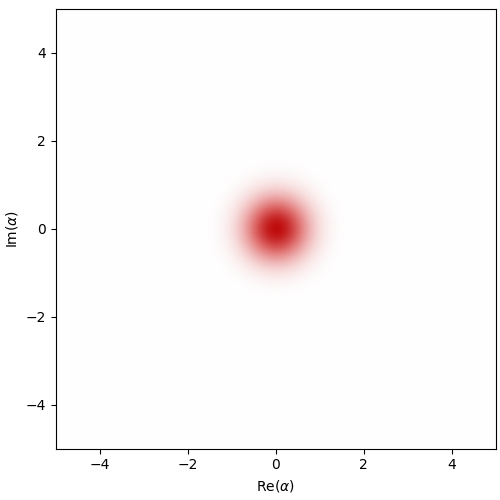

In [11]:
rho_1 = dq.ptrace(res.states, 0)
dq.plot.wigner_gif(rho_1)

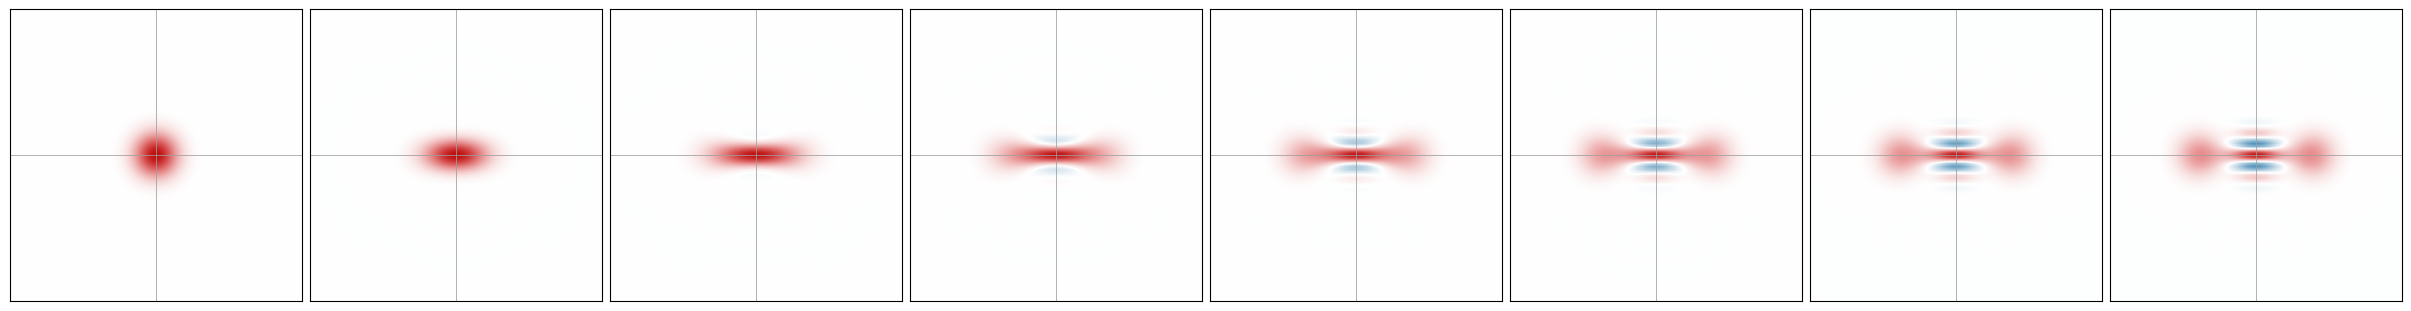

In [12]:
#Plot Wigner mosaic - Wigner functions at different times
dq.plot.wigner_mosaic(rho_1, cross = True)

c:\Users\pranv\alice-bob\venv\Lib\site-packages\jax\_src\ops\scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
c:\Users\pranv\alice-bob\venv\Lib\site-packages\jax\_src\ops\scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


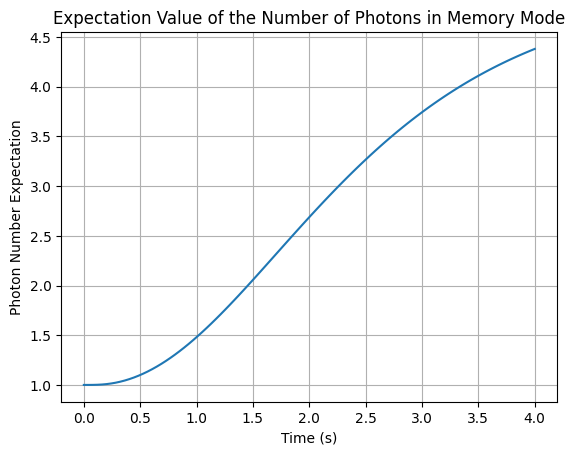

In [48]:
# Plot the expectation value of the number of photons in the memory mode
a_op = dq.destroy(n_a)
num_op_a = a_op @ a_op.dag()
size = len(rho_1)
photon_expect = jnp.zeros(size)
for i in range(size):
    val = dq.expect(num_op_a, rho_1[i])
    photon_expect = photon_expect.at[i].set(val)
# plt.figure(figsize=(8, 5))
plt.plot(ts, photon_expect)
plt.xlabel("Time (s)")
plt.ylabel("Photon Number Expectation")
plt.title("Expectation Value of the Number of Photons in Memory Mode")
plt.grid()
plt.show()

c:\Users\pranv\alice-bob\venv\Lib\site-packages\jax\_src\ops\scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
c:\Users\pranv\alice-bob\venv\Lib\site-packages\jax\_src\ops\scatter.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


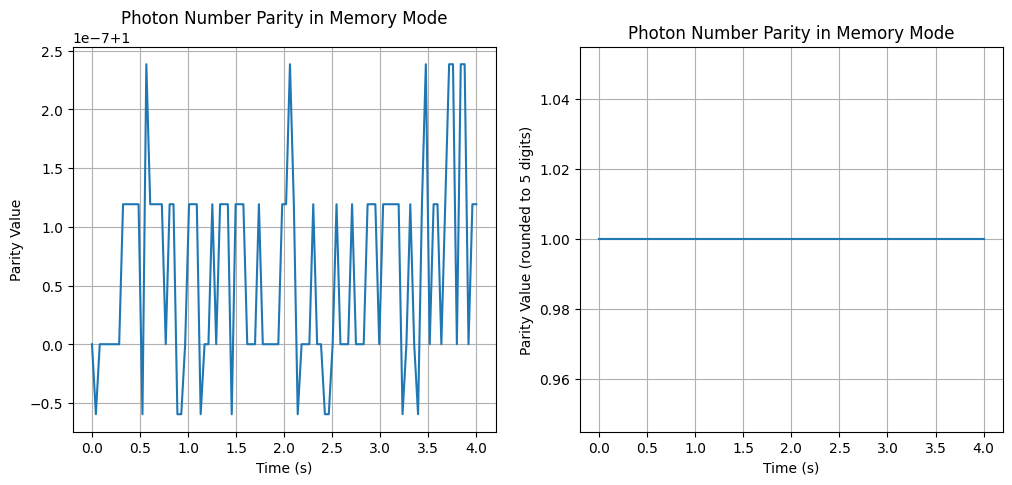

In [5]:
# Plot the photon number parity in the memory mode

# Define parity operator for memory mode
parity_op = dq.parity(n_a)  

# Calculate the parity values for each time step
size = len(rho_1)
parity_val = jnp.zeros(size)
for i in range(size):
    val = dq.expect(parity_op, rho_1[i])
    parity_val = parity_val.at[i].set(val)

parity_val_rounded = np.round(parity_val, 5)
# plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(ts, parity_val)
ax[1].plot(ts, parity_val_rounded)
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Parity Value")
ax[0].set_title("Photon Number Parity in Memory Mode")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Parity Value (rounded to 5 digits)")
ax[1].set_title("Photon Number Parity in Memory Mode")
ax[0].grid()
ax[1].grid()
plt.show()

### **Results**
- The Wigner function confirms the formation of a **cat state** with characteristic **interference fringes**, which indicate quantum coherence.
- The **two-photon dissipation mechanism** stabilizes the cat state against bit-flip errors.

### **Conclusion**
This simulation demonstrates how a cat qubit can be **stabilized using a dissipative mechanism** by coupling to a lossy buffer mode. The approach showcases a fundamental concept in **bosonic quantum error correction**, which is a key feature of superconducting cat qubits.

## **Task 1.2 - Comparison with eliminated buffer mode (Function of Losee Operator)**

In this task, we simulate a system where we eliminate the buffer mode adiabatically. We are given the dynamics of the system in memory mode through the differential equation in the problem statement, which models the loss operator $L_{2}$. Again, we eveolve the system under this new Hamiltonian for $4$ units of time. Finally, we compare the fidelity of the states obtained with those obtained the two-mode system from Task 1.1.

In [13]:
## Defining Parameters ##
# Parameters carried over from Task 1.1
g_2 = 1.0
e_d = -4
kappa_b = 10

# Parameters given in problem statement for Task 1.2
kappa_2 = 4*abs(g_2)**2/kappa_b
alpha_sq = -e_d/g_2 # (g_2* = g_2 since g_2 is real)

#Define Hilbert space truncation
n_a = 20  # Memory mode
n_b = 5   # Buffer mode

In [14]:
## Define State and Operators ##
a = dq.destroy(n_a)

# initial coherent state
psi0 = dq.coherent(n_a, 0)

# Define Hamiltonian
H = dq.eye(n_a) # -- all modes are identity matrix, since the system does not have a buffer mode

# Define Loss Operator
alpha_mat = alpha_sq * dq.eye(n_a)
L = [jnp.sqrt(kappa_2) * (a @ a - alpha_mat)]

|██████████| 100.0% ◆ elapsed 59.39ms ◆ remaining 0.00ms
100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


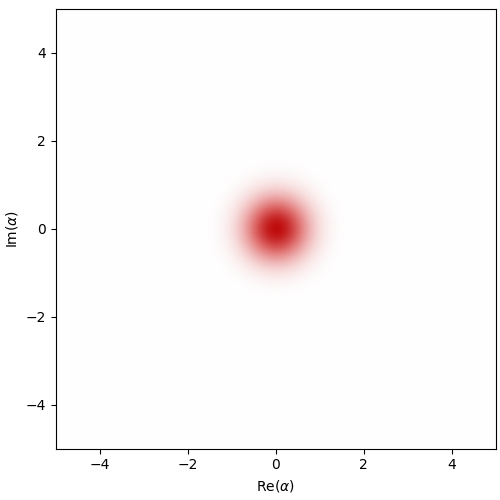

In [15]:
## Performing Time Evolution ##
ts = jnp.linspace(0, 4, 100)

# Solving the master equation
res = dq.mesolve(H, L, psi0, ts)
rho_2 = dq.ptrace(res.states, 0)

#Visualize through Wigner function animation
dq.plot.wigner_gif(rho_2)

From this Wigner function plot, we can see how the system moves from the initial localized Gaussian state (vacuum state),  spreads out over time, and eventually creates an interference pattern and a multi-lobed pattern, same as in Task 1.1. This is a signature of the cat state, which is a superposition of two coherent states. Thus, the graph exhibits the characteristic properties of an ideal dissipator used in the system.

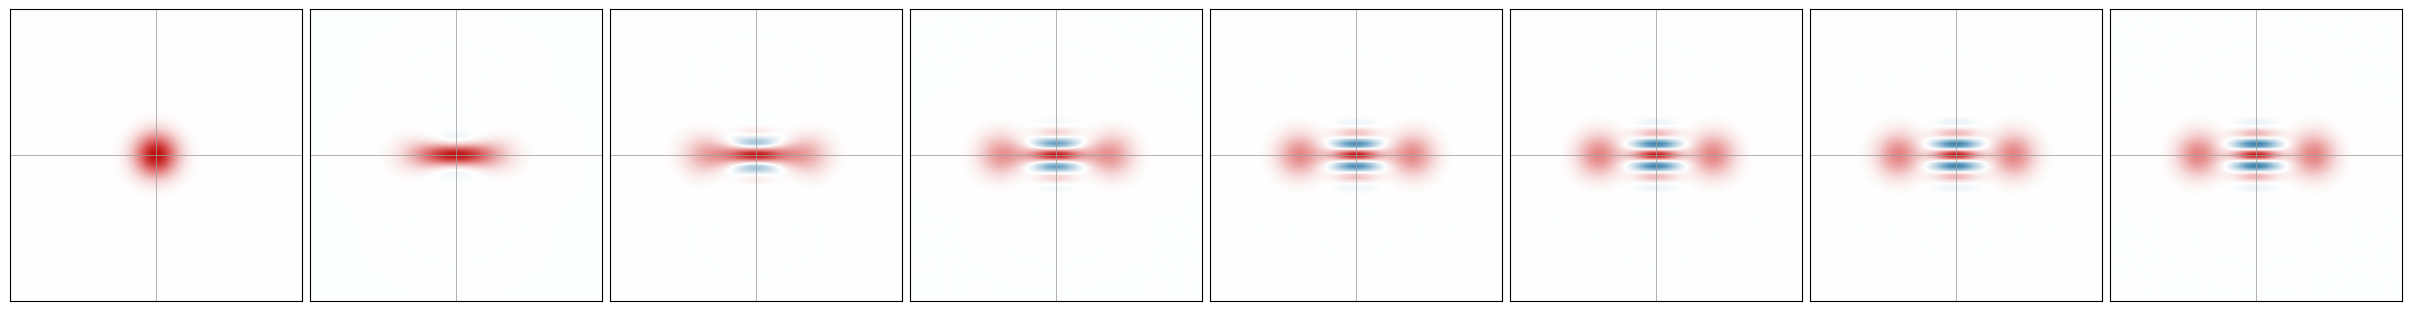

In [16]:
#Plot Wigner mosaic - Wigner functions at different times (static representation)
dq.plot.wigner_mosaic(rho_2, cross = True)

### **Fidelity of states from systems in Task 1.1 vs task 1.2**

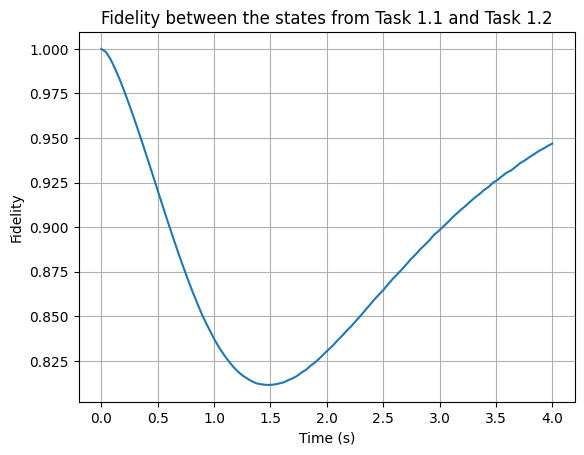

In [17]:
# Time-evolution of fidelity between the states from Task 1.1 and Task 1.2

size = len(rho_1) # number of time states from Task 1.1
fidelity_vals = jnp.zeros(size)
# Calculate the fidelity values for each time step
for i in range(size):
    val = dq.fidelity(rho_1[i], rho_2[i])
    fidelity_vals = fidelity_vals.at[i].set(val)

plt.plot(ts, fidelity_vals)
plt.xlabel("Time (s)")
plt.ylabel("Fidelity")
plt.title("Fidelity between the states from Task 1.1 and Task 1.2")
plt.grid()
plt.show()
    

The fidelity plot matches our expectations. It shows an initial strong match (fidelity ~ 1 as both states are initialized to vacuum states), with a sharp dip as the dissipative drivers (i.e. lack of buffer mode in Task 1.2) show their effect. However, over time the fidelity recovers due to the periodic nature of the memory node, allowing it to realign with the two-mode system. Hence, memory mode can behave as a photon dissipation stabilizer.

### Lowering Kappa_b to see the impact on Fidelity

In [18]:
# returns fidelity values for each time step
def get_fidelity(rho_1, rho_2):
    size = len(rho_1)
    fidelity = jnp.zeros(size)
    for i in range(size):
        val = dq.fidelity(rho_1[i], rho_2[i])
        fidelity = fidelity.at[i].set(val)
    return fidelity

In [19]:
kappa_b = np.linspace(10, 1, 6)
size = len(kappa_b)
fidelity_data = jnp.zeros((size, len(ts)))
ts = jnp.linspace(0, 4, 100) #Time evolution parameter
i = 0

for Kb in kappa_b:
    g_2 = 1.0     #Define parameters
    e_d = -4
    kappa_2 = 4*abs(g_2)**2/Kb
    alpha_sq = -e_d/g_2

    #Define Hilbert space truncation
    n_a = 20  # Memory mode
    n_b = 5   # Buffer mode

    a = dq.tensor(dq.destroy(n_a), dq.eye(n_b))
    b = dq.tensor(dq.eye(n_a), dq.destroy(n_b))
    a_2 = dq.destroy(n_a)

    #Define initial state
    psi1 = dq.coherent((n_a, n_b), [0, 0])
    psi2 = dq.coherent(n_a, 0)

    #Define Hamiltonian
    H_1 = g_z * (a.dag() @ a.dag() @ b + a @ a @ b.dag()) + e_d * (b + b.dag())
    H_2 = dq.eye(n_a) # -- All identity

    #Define dissipators
    L_1 = [jnp.sqrt(Kb) * b]
    alpha_mat = alpha_sq * dq.eye(n_a)
    L_2 = [jnp.sqrt(kappa_2) * (a_2 @ a_2 - alpha_mat)]

    #Solve Master Equation
    res_1 = dq.mesolve(H_1, L_1, psi1, ts)
    res_2 = dq.mesolve(H_2, L_2, psi2, ts)
    rho_1 = dq.ptrace(res_1.states, 0)
    rho_2 = dq.ptrace(res_2.states, 0)
    fidelity = get_fidelity(rho_1, rho_2)
    fidelity_data = fidelity_data.at[i, :].set(fidelity)
    i = i+1

|██████████| 100.0% ◆ elapsed 411.15ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 40.38ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 351.93ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 50.27ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 351.72ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 64.79ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 350.35ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 89.40ms ◆ remaining 0.00ms
|██████████| 100.0% ◆ elapsed 348.56ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 145.12ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 365.20ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 392.02ms ◆ remaining 0.00ms  


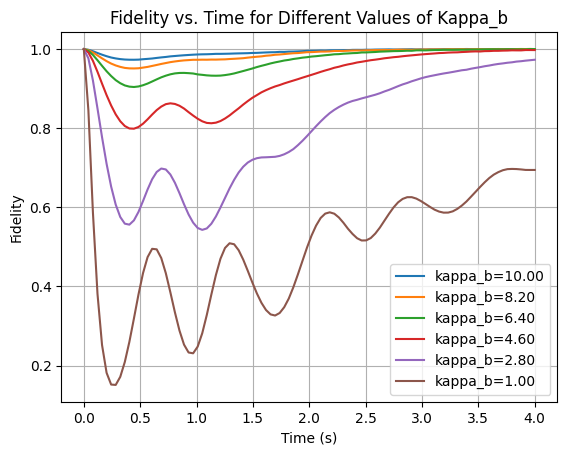

In [20]:
for i, Kb in enumerate(kappa_b):
    plt.plot(ts, fidelity_data[i], label=f'kappa_b={Kb:.2f}')

plt.xlabel('Time (s)')
plt.ylabel('Fidelity')
plt.title('Fidelity vs. Time for Different Values of Kappa_b')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

From this plot, we see kappa_b decides the buffer mode decay rate. As kappa_b decreases, the fidelity vs. time graph transitions from a stabilized regime (high fidelity, minimal oscillations) to a strongly oscillatory regime (low fidelity, long deviations). This aligns with expectations - with smaller values of kappa_b i.e. smaller buffer drive rate, the buffer mode cannot dissipate energy effectively, reducing fidelity with the reference state. Thus, higher values of kappa_b are required to create the needed timescale separation between the memory mode and the buffer mode.

<hr/>